# Классификация рукописных цифр

## Загрузка датасета MNIST с Kaggle

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/c/digit-recognizer/overview")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading digit-recognizer.zip to ./digit-recognizer


100%|██████████| 15.3M/15.3M [00:00<00:00, 1.14GB/s]


Extracting archive ./digit-recognizer/digit-recognizer.zip to ./digit-recognizer


## Импорт библиотек

In [37]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.18.0


In [5]:
print(tf.executing_eagerly())

True


## Сохраняем csv файлы в массивы

In [6]:
train = np.loadtxt('digit-recognizer/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('digit-recognizer/test.csv', delimiter=',', skiprows=1)

In [7]:
print(type(train))

<class 'numpy.ndarray'>


In [8]:
print(train.shape, test.shape)

(42000, 785) (28000, 784)


## Сохраняем разметку в отдельную переменную

In [9]:
train_label = train[:, 0]

In [10]:
train_label.shape

(42000,)

In [11]:
print(train_label[:10])

[1. 0. 1. 4. 0. 0. 7. 3. 5. 3.]


## Приводим размерность к удобному для обработки виду

In [12]:
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28, 1))
test_img = np.resize(test, (test.shape[0], 28, 28, 1))

In [13]:
print(train_img.shape, test_img.shape)

(42000, 28, 28, 1) (28000, 28, 28, 1)


## Визуализируем исходные данные

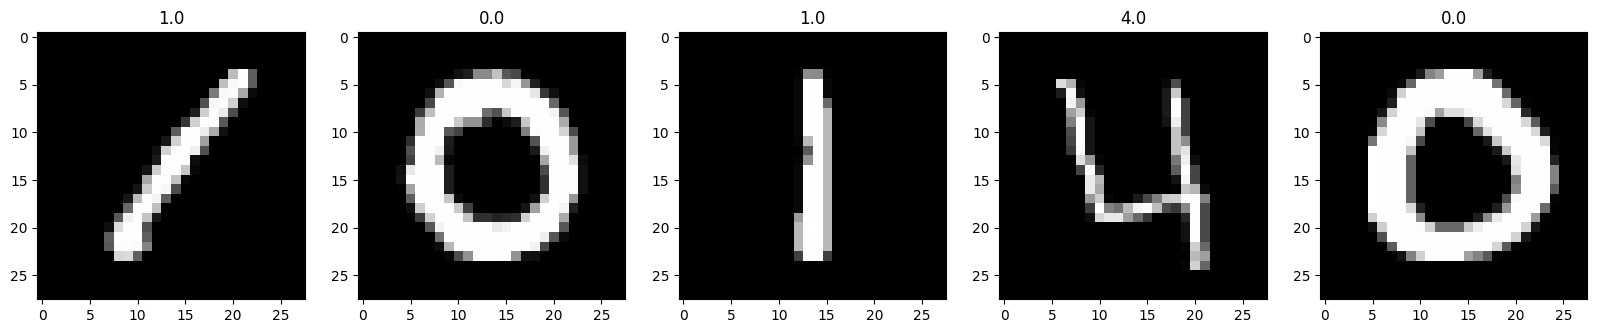

In [14]:
fig = plt.figure(figsize=(20, 20))
for i, img in enumerate(train_img[0:5, :], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[:, :, 0], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Разбиваем выборку на обучение и валидацию

In [15]:
y_train, y_val, x_train, x_val = train_test_split(
    train_label,
    train_img,
    test_size=0.2,
    random_state=42
)

In [16]:
print(y_train.shape, x_train.shape)

(33600,) (33600, 28, 28, 1)


In [17]:
print(y_val.shape, x_val.shape)

(8400,) (8400, 28, 28, 1)


## Собираем сверточную сеть для обучения

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=6,
        kernel_size=(5, 5),
        padding='same',
        activation='relu',
        input_shape=x_train.shape[1:]
    ),
    tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        padding='valid'
    ),
    tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(5, 5),
        padding='same',
        activation='relu',
        input_shape=x_train.shape[1:]
    ),
    tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        padding='valid'
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,022 (109.46 KB)

 Trainable params: 28,022 (109.46 KB)

 Non-trainable params: 0 (0.00 B)

## One-hot кодировка разметки

In [21]:
y_train_labels = tf.keras.utils.to_categorical(y_train)

In [22]:
print(y_train.shape)
print(y_train_labels.shape)

(33600,)
(33600, 10)


## Запускаем обучение

In [23]:
model.fit(
    x_train,
    y_train_labels,
    batch_size=32,
    epochs=5,
    validation_split=0.2
)

Epoch 1/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6670 - loss: 2.1106 - val_accuracy: 0.9488 - val_loss: 0.1821
Epoch 2/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9604 - loss: 0.1328 - val_accuracy: 0.9601 - val_loss: 0.1528
Epoch 3/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9746 - loss: 0.0829 - val_accuracy: 0.9692 - val_loss: 0.1200
Epoch 4/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9820 - loss: 0.0550 - val_accuracy: 0.9705 - val_loss: 0.1129
Epoch 5/5
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9837 - loss: 0.0512 - val_accuracy: 0.9743 - val_loss: 0.1108


## Предсказываем класс объекта

In [24]:
y_pred = model.predict(x_val)
y_pred_labels = np.argmax(y_pred, axis=1)

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [29]:
print(y_pred.shape)
print(y_pred_labels.shape)

(8400, 10)
(8400,)


In [26]:
y_pred[:1]

array([[4.7994064e-11, 2.6417515e-08, 6.2443792e-07, 3.1928560e-09,
        1.1473220e-13, 1.1502391e-08, 3.2455683e-09, 4.4815884e-09,
        9.9999928e-01, 4.4405361e-08]], dtype=float32)

In [31]:
y_pred_labels

array([8, 1, 9, ..., 3, 0, 9])

## Оцениваем качество решения на валидационной выборке

In [33]:
print('Accoracy: %s' % accuracy_score(y_val, y_pred_labels))

Accoracy: 0.9729761904761904


In [36]:
print(classification_report(y_val, y_pred_labels))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       816
         1.0       0.99      0.98      0.99       909
         2.0       0.99      0.96      0.98       846
         3.0       0.97      0.98      0.97       937
         4.0       0.99      0.97      0.98       839
         5.0       0.98      0.96      0.97       702
         6.0       0.97      0.99      0.98       785
         7.0       0.98      0.97      0.98       893
         8.0       0.92      0.98      0.95       835
         9.0       0.96      0.97      0.96       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



Text(0, 0.5, 'True labels')

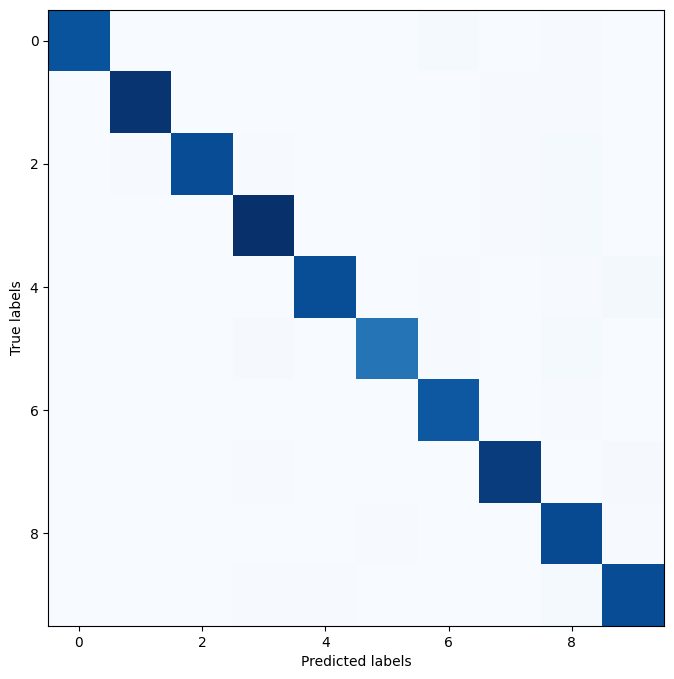

In [38]:
cm = confusion_matrix(y_val, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")